# Data Loading

In [1]:
import pandas as pd
import os

data_dir = "../data"
#Read the data from data folder
user_sample = pd.read_json(os.path.join(data_dir, "user_sample.json"), lines=True)
edge_sample = pd.read_csv(os.path.join(data_dir, "edge_sample.csv"))
label_sample = pd.read_csv(os.path.join(data_dir, "label_sample.csv"))


# Centrality Analysis for HGNN Feature

In [2]:
import networkx as nx
G = nx.Graph()  # Create an undirected graph


for index, row in edge_sample.iterrows():
    if row['relation'] == 'following':
        G.add_edge(row['source_id'], row['target_id']) # Add following relationships into the graph
    

In [3]:
label = {}
for index, row in label_sample.iterrows():
    label[row['id']] = row['label'] # Transform the label of users into dict

In [4]:
# Compute centrality measures
degree_centrality = nx.degree_centrality(G)  # Degree Centrality
betweenness_centrality = nx.betweenness_centrality(G)  # Betweenness Centrality
closeness_centrality = nx.closeness_centrality(G)  # Closeness Centrality

# Hypergraph Construction

In [5]:
import easygraph as eg

/Users/boen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
#select the following relationships to build the hypergraph
following_edges = edge_sample[edge_sample['relation'] == 'following']
following_edges = following_edges.drop_duplicates()

In [7]:
grouped_edges = following_edges.groupby('source_id')['target_id'].apply(tuple).to_dict()

In [8]:
#group the followers of each users
grouped_edges = following_edges.groupby('source_id')['target_id'].apply(tuple).to_dict()


In [9]:
source_ids = list(set(list(following_edges['source_id'])))
#Build the hypergraph according to co-following relationships
hyperedges = list(grouped_edges[target_id] for target_id in source_ids)


In [10]:
hyperedges

[('u99665921',),
 ('u1273759306039558145',),
 ('u1584137959', 'u595982444', 'u809479999296335872', 'u16055364'),
 ('u30354991', 'u357606935'),
 ('u1153063439264301058',),
 ('u44196397', 'u16303106'),
 ('u357606935', 'u17264476'),
 ('u783214',),
 ('u1245136726626119687',),
 ('u783214', 'u44196397'),
 ('u1210956763618394113',),
 ('u381289719', 'u342181234'),
 ('u21114659', 'u30354991'),
 ('u30354991',),
 ('u44196397', 'u20571756'),
 ('u783214',),
 ('u44196397', 'u28785486'),
 ('u26565946', 'u75916180'),
 ('u783214', 'u474154291', 'u44196397'),
 ('u30354991', 'u357606935', 'u25864331'),
 ('u783214', 'u98047213', 'u886832413'),
 ('u15143478', 'u4939401'),
 ('u44196397',),
 ('u28785486',),
 ('u44196397',),
 ('u44196397',),
 ('u476582730',
  'u1720046887',
  'u381289719',
  'u22385548',
  'u2999992556',
  'u50343115'),
 ('u47472893', 'u44196397'),
 ('u747212842470891520', 'u1720046887', 'u2465283662'),
 ('u27260086', 'u26565946'),
 ('u44196397', 'u1319516983231090689', 'u2465283662', 'u17200

# Integrate the node features, node labels

In [11]:
import torch
node_to_index = {}
node_labels = []
node_feats = []
for index, row in user_sample.iterrows():
    node_to_index[row['id']] = index
    id = row['id']
    if label[id] == 'human':
        node_labels.append(0)
    else:
        node_labels.append(1)
    try:
        node_feats.append([degree_centrality[id], betweenness_centrality[id], closeness_centrality[id], row['public_metrics']['followers_count'], row['public_metrics']['tweet_count']])
    except:
        node_feats.append([0,0,0, row['public_metrics']['followers_count'], row['public_metrics']['tweet_count']])

node_labels = torch.tensor(node_labels)
node_feats = torch.tensor(node_feats)

In [12]:
indexed_hyperedge_list = [tuple(node_to_index[node] for node in edge) for edge in hyperedges]
hg = eg.Hypergraph(num_v=len(node_to_index),e_list=indexed_hyperedge_list)
hg

Hypergraph(num_vertex=1000, num_hyperedge=479)

In [13]:
import numpy as np
# random seed
np.random.seed(42)


n = 1000
indices = np.arange(n)

np.random.shuffle(indices)

# tran_val_test split
train_end = int(0.7 * n)  
val_end = int(0.8 * n)   

train_mask = np.zeros(n, dtype=bool)
val_mask = np.zeros(n, dtype=bool)
test_mask = np.zeros(n, dtype=bool)

train_mask[indices[:train_end]] = True
val_mask[indices[train_end:val_end]] = True
test_mask[indices[val_end:]] = True

print(f"Train mask (70% of data): {train_mask}")
print(f"Validation mask (10% of data): {val_mask}")
print(f"Test mask (20% of data): {test_mask}")

Train mask (70% of data): [ True False  True  True False  True  True  True  True  True  True  True
  True False False  True  True  True  True  True False False  True  True
  True  True  True False  True  True  True  True False  True False False
  True  True  True  True False  True  True  True  True  True  True False
  True  True  True  True False  True  True  True  True  True False  True
  True  True False  True False  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True False  True  True  True
  True False  True False  True  True  True False  True  True  True False
  True  True False False  True  True False  True  True False False  True
  True  True  True  True False  True  True  True  True  True  True  True
  True False False False  True  True  True  True False False False  True
  True  True False  True  True  True False  True  True  True  True False
  True  True False False  True  True  True  True  True  True  True  True
 False  True  True False 

# Hypergraph neural network training

In [15]:
X = node_feats
y = node_labels
num_classes = 2
input_feature_dim = X.shape[1]
hidden_dim = 128
dataset = {}
dataset["structure"] = hg
dataset["features"] = X
dataset["labels"] = y
dataset["train_mask"] = train_mask
dataset["val_mask"] = val_mask
dataset["test_mask"] = test_mask
dataset["num_classes"] = num_classes


In [16]:
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
model = eg.HGNN(in_channels = input_feature_dim, hid_channels = hidden_dim,
                     num_classes = num_classes)

def train(
    data: dict,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,):

    features, structure = data["features"], data["structure"]
    train_mask, labels = data["train_mask"], data["labels"]
    optimizer.zero_grad()
    outputs = model(features, structure)

    

    loss = criterion(outputs[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def valid(model: nn.Module, data: dict):
    features, structure = data["features"], data["structure"]
    val_mask, labels = data["val_mask"], data["labels"]
    model.eval()
    outputs = model(features, structure).argmax(dim=1)
    correct = (outputs[val_mask] == labels[val_mask]).sum()
    acc = int(correct) / len(val_mask)
    return acc

@torch.no_grad()
def test(model: nn.Module, data: dict):
    features, structure = data["features"], data["structure"]
    val_mask, labels = data["test_mask"], data["labels"]
    outputs = model(features, structure).argmax(dim=1)
    correct = (outputs[val_mask] == labels[val_mask]).sum()
    acc = int(correct) / len(val_mask)

    pred_probs = torch.softmax(model(features, structure), dim=1)
    # Get the label of test data
    y_true = y[test_mask].cpu().numpy()
    # Get the probability of prediction for test dataset
    y_scores = pred_probs[test_mask].cpu().numpy()
    auc = roc_auc_score(y_true, y_scores[:, 1]) # 0:human, 1:bot

    return acc,auc

In [17]:
def draw_loss_curve(loss1, save_path = "loss_pic.pdf"):
    plt.clf()
    epochs = range(1, len(loss1) + 1)
    plt.plot(epochs, loss1, 'b', label='HGNN Training loss')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    #if save_path is not None:
        #plt.savefig(save_path)
    plt.show()

epoch: 0, valid accuracy : 0.056, loss : 1162.394775390625
epoch: 20, valid accuracy : 0.083, loss : 2277.580322265625
epoch: 40, valid accuracy : 0.083, loss : 1387.3402099609375
epoch: 60, valid accuracy : 0.085, loss : 1106.435546875
epoch: 80, valid accuracy : 0.085, loss : 1396.80859375
epoch: 100, valid accuracy : 0.086, loss : 1937.6484375
epoch: 120, valid accuracy : 0.086, loss : 943.451416015625
epoch: 140, valid accuracy : 0.085, loss : 838.0369873046875
epoch: 160, valid accuracy : 0.085, loss : 434.2257080078125
epoch: 180, valid accuracy : 0.085, loss : 182.26817321777344
epoch: 200, valid accuracy : 0.056, loss : 87.71102142333984
epoch: 220, valid accuracy : 0.085, loss : 285.30377197265625
epoch: 240, valid accuracy : 0.085, loss : 436.04852294921875
epoch: 260, valid accuracy : 0.085, loss : 543.3937377929688
epoch: 280, valid accuracy : 0.086, loss : 585.287109375
epoch: 300, valid accuracy : 0.085, loss : 612.8563842773438
epoch: 320, valid accuracy : 0.085, loss : 

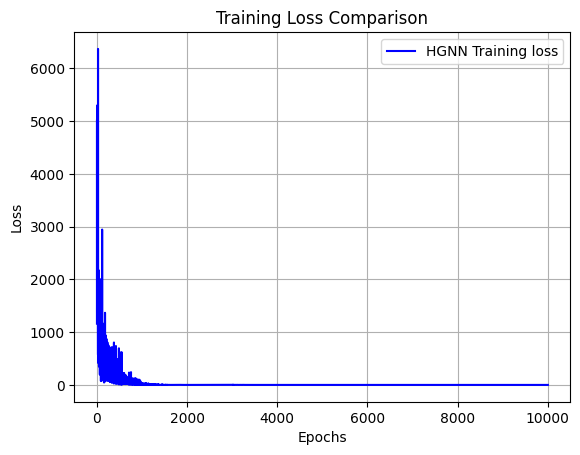

In [19]:
loss_lst = []
epoch = 10000
lr = 0.01
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
model.train()
for i in range(epoch):
    loss = train(data = dataset, model = model, optimizer=optimizer, criterion=loss_fn)
    loss_lst.append(loss.detach().numpy())
    val_acc = valid(model = model, data = dataset)
    if i % 20 == 0:
        print(f"epoch: {i}, valid accuracy : {val_acc}, loss : {loss}")
print("Training finish!")
test_acc,test_auc = test(model = model, data=dataset)
print("test accuracy:", test_acc)
print("test rocauc:", test_auc)
draw_loss_curve(loss_lst)

### Analysis of Model Performance

- **Test Accuracy**: 0.169 
- **Test ROC AUC Score**: 0.609

These results indicate that the model's performance is not optimal. One possible reason for this is:

- The dataset's limited following relationships, which reduces the ability to fully capture group interactions among users. This limitation makes it harder for the model to effectively distinguish between human and bot accounts, as it relies on co-following relationships to form hyperedges.

Despite the relatively low performance, the method itself represents an innovative approach:

- **Hypergraph Structure**: The model leverages a hypergraph structure to capture group interactions, an area where traditional pairwise methods fall short. This approach shows promise in overcoming the limitations of conventional graph-based models, especially in modeling higher-order user interactions.

### Future Work
- **Hypergraph Expansion**: Future work could involve expanding the hypergraph construction to incorporate additional relationships, such as:
  - Co-following
  - Co-hashtags
  - Co-retweets  

By integrating these diverse types of interactions, the model could capture a broader range of group behaviors, potentially leading to improved accuracy in bot detection.
